In [44]:
import torch
import torch.nn.functional as F
import torch_geometric
import numpy as np
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.transforms import ToUndirected
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import matplotlib.pyplot as plt
import networkx as nx
import time
from tabulate import tabulate
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Load the dataset

In [45]:
with torch.serialization.safe_globals({
    torch_geometric.data.data.DataEdgeAttr,
    torch_geometric.data.data.DataTensorAttr,
    torch_geometric.data.storage.GlobalStorage
}):
    dataset = PygNodePropPredDataset(name="ogbn-arxiv", transform=ToUndirected())
    data = dataset[0]


### Dataset splitting

In [46]:
split_idx = dataset.get_idx_split()
train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx = split_idx["test"]

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = train_idx.to(device)
valid_idx = valid_idx.to(device)
test_idx = test_idx.to(device)


### Details About Dataset

In [48]:
info = [
    ["Dataset", str(dataset)],
    ["Data object", str(data)],
    ["Number of nodes", data.num_nodes],
    ["Number of edges", data.num_edges],
    ["Number of features", dataset.num_node_features],
    ["Number of classes", dataset.num_classes]
]

print(tabulate(info, headers=["Attribute", "Value"], tablefmt="github"))

| Attribute          | Value                                                                                                  |
|--------------------|--------------------------------------------------------------------------------------------------------|
| Dataset            | PygNodePropPredDataset()                                                                               |
| Data object        | Data(num_nodes=169343, edge_index=[2, 2315598], x=[169343, 128], node_year=[169343, 1], y=[169343, 1]) |
| Number of nodes    | 169343                                                                                                 |
| Number of edges    | 2315598                                                                                                |
| Number of features | 128                                                                                                    |
| Number of classes  | 40                                                                               

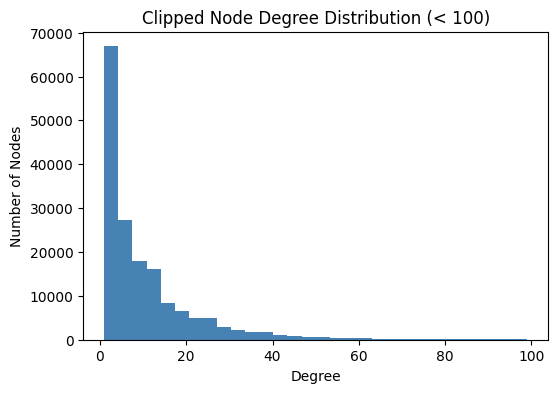

In [49]:
degrees = torch.bincount(data.edge_index[0])
degrees_np = degrees.cpu().numpy()
clipped_degrees = degrees_np[degrees_np < 100]

plt.figure(figsize=(6,4))
plt.hist(clipped_degrees, bins=30, color='steelblue')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Clipped Node Degree Distribution (< 100)")
plt.show()

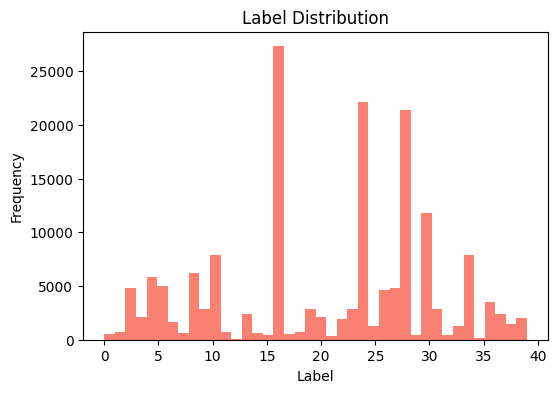

In [50]:
plt.figure(figsize=(6,4))
plt.hist(data.y.cpu().numpy(), bins=dataset.num_classes, color='salmon')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Label Distribution")
plt.show()

### Define the models.   in this ,we are use GCN,GraphSAGE and GAT GNN architechtures and compare the accuracy and performance of those models

In [51]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [52]:
def train_and_evaluate(model, model_name):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    evaluator = Evaluator(name="ogbn-arxiv")

    train_accs, val_accs, test_accs, times = [], [], [], []

    for epoch in range(1, 80):
        model.train()
        start_time = time.time()

        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[train_idx], data.y.squeeze(1)[train_idx])
        loss.backward()
        optimizer.step()

        end_time = time.time()
        times.append(end_time - start_time)

        model.eval()
        pred = out.argmax(dim=-1, keepdim=True)

        train_acc = evaluator.eval({
            'y_true': data.y[train_idx],
            'y_pred': pred[train_idx],
        })['acc']
        val_acc = evaluator.eval({
            'y_true': data.y[valid_idx],
            'y_pred': pred[valid_idx],
        })['acc']
        test_acc = evaluator.eval({
            'y_true': data.y[test_idx],
            'y_pred': pred[test_idx],
        })['acc']

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        print(f"[{model_name}] Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f} | Time: {end_time - start_time:.2f}s")

    return train_accs, val_accs, test_accs, times, model

In [53]:
results = {}
final_models = {}

for name, model_class in [
    ("GCN", GCN),
    ("GraphSAGE", GraphSAGE),
    ("GAT", GAT)
]:
    print(f"\nTraining {name} model...\n")
    model = model_class(dataset.num_node_features, 128, dataset.num_classes)
    train_accs, val_accs, test_accs, times, trained_model = train_and_evaluate(model, name)
    results[name] = (train_accs, val_accs, test_accs, times)
    final_models[name] = trained_model


Training GCN model...

[GCN] Epoch 001 | Loss: 3.6721 | Train Acc: 0.0246 | Val Acc: 0.0102 | Test Acc: 0.0116 | Time: 0.05s
[GCN] Epoch 002 | Loss: 3.3730 | Train Acc: 0.1795 | Val Acc: 0.0773 | Test Acc: 0.0595 | Time: 0.05s
[GCN] Epoch 003 | Loss: 3.1447 | Train Acc: 0.1791 | Val Acc: 0.0763 | Test Acc: 0.0586 | Time: 0.04s
[GCN] Epoch 004 | Loss: 3.0637 | Train Acc: 0.1791 | Val Acc: 0.0763 | Test Acc: 0.0586 | Time: 0.04s
[GCN] Epoch 005 | Loss: 3.0252 | Train Acc: 0.2762 | Val Acc: 0.2981 | Test Acc: 0.2683 | Time: 0.04s
[GCN] Epoch 006 | Loss: 2.9767 | Train Acc: 0.2806 | Val Acc: 0.3022 | Test Acc: 0.2704 | Time: 0.04s
[GCN] Epoch 007 | Loss: 2.9090 | Train Acc: 0.2874 | Val Acc: 0.3040 | Test Acc: 0.2727 | Time: 0.04s
[GCN] Epoch 008 | Loss: 2.8469 | Train Acc: 0.2839 | Val Acc: 0.2982 | Test Acc: 0.2692 | Time: 0.04s
[GCN] Epoch 009 | Loss: 2.7904 | Train Acc: 0.2885 | Val Acc: 0.3046 | Test Acc: 0.2832 | Time: 0.05s
[GCN] Epoch 010 | Loss: 2.7298 | Train Acc: 0.3075 | Val A

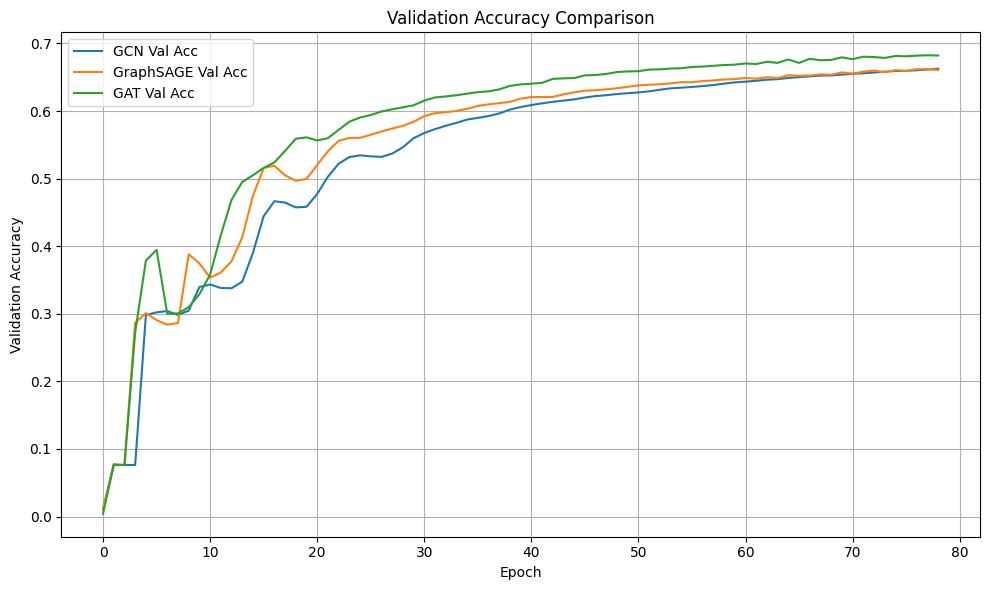

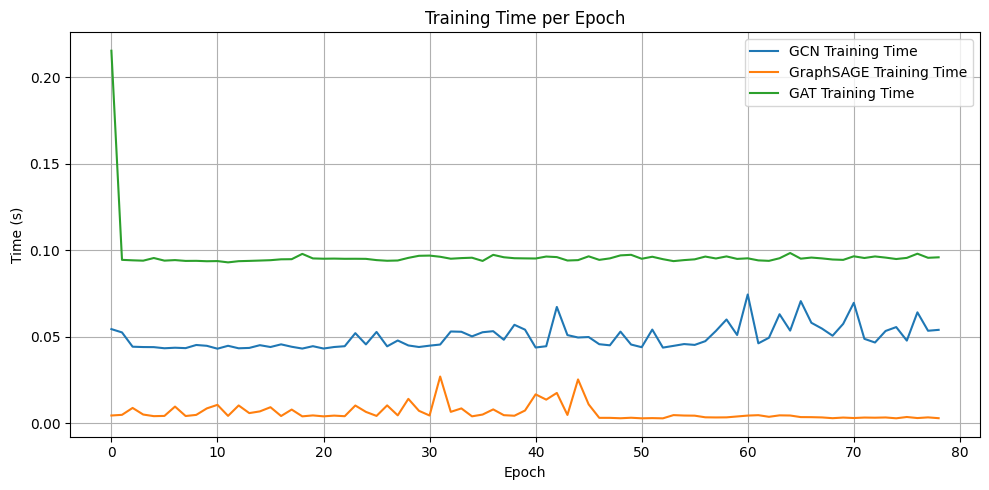

In [54]:
plt.figure(figsize=(10, 6))
for name in results:
    plt.plot(results[name][1], label=f"{name} Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for name in results:
    plt.plot(results[name][3], label=f"{name} Training Time")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Training Time per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualizations

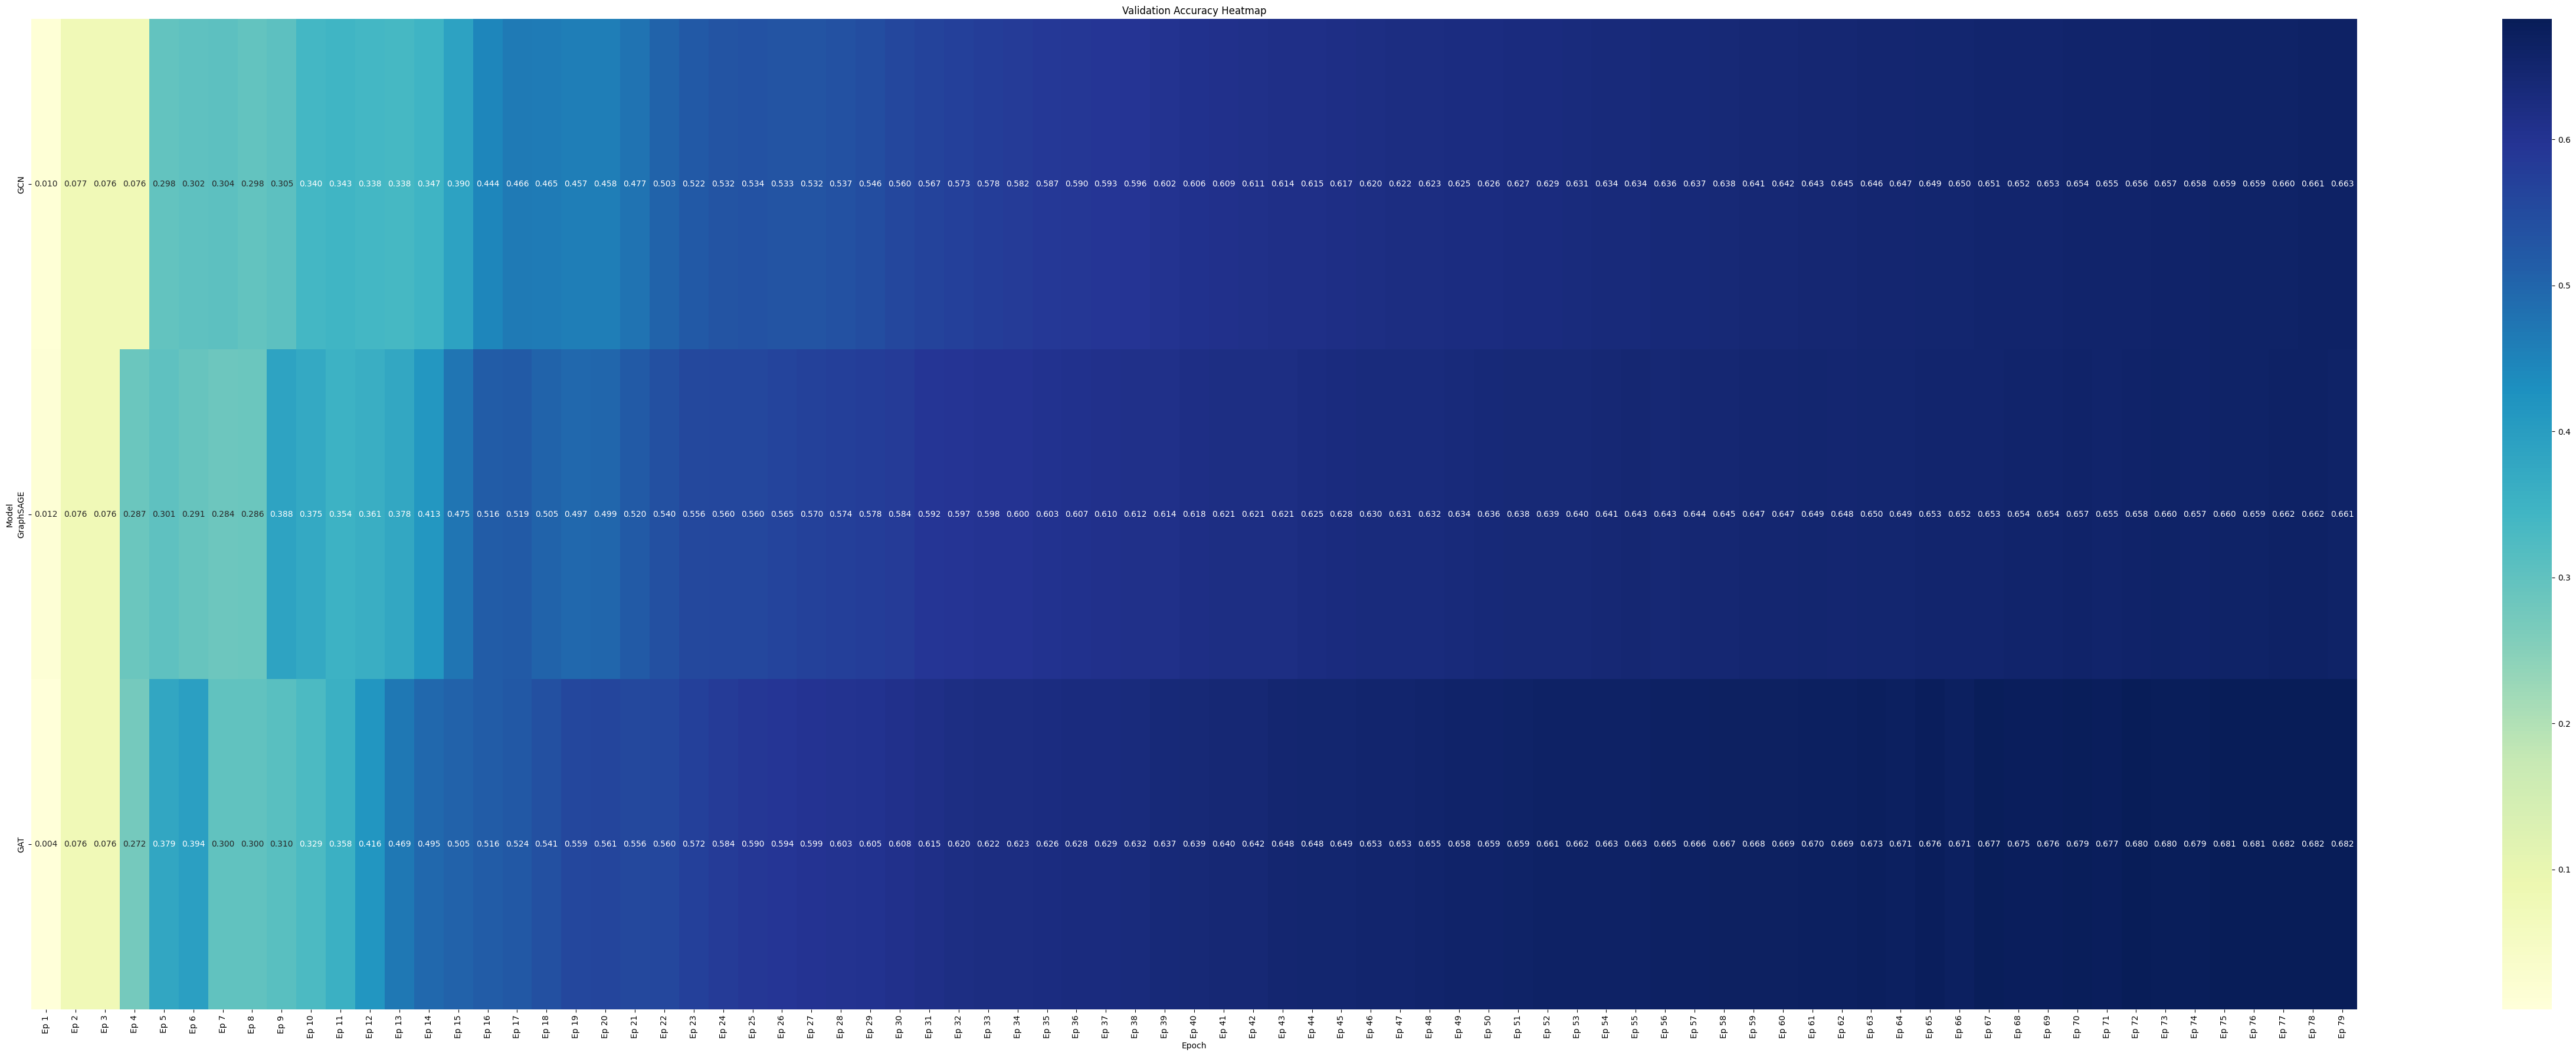

In [60]:
acc_matrix = np.array([results[m][1] for m in results])  # shape (3, epochs)
plt.figure(figsize=(50,18))
sns.heatmap(acc_matrix, annot=True, fmt=".3f", cmap="YlGnBu",
            xticklabels=[f"Ep {i+1}" for i in range(acc_matrix.shape[1])],
            yticklabels=list(results.keys()))
plt.title("Validation Accuracy Heatmap")
plt.xlabel("Epoch")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


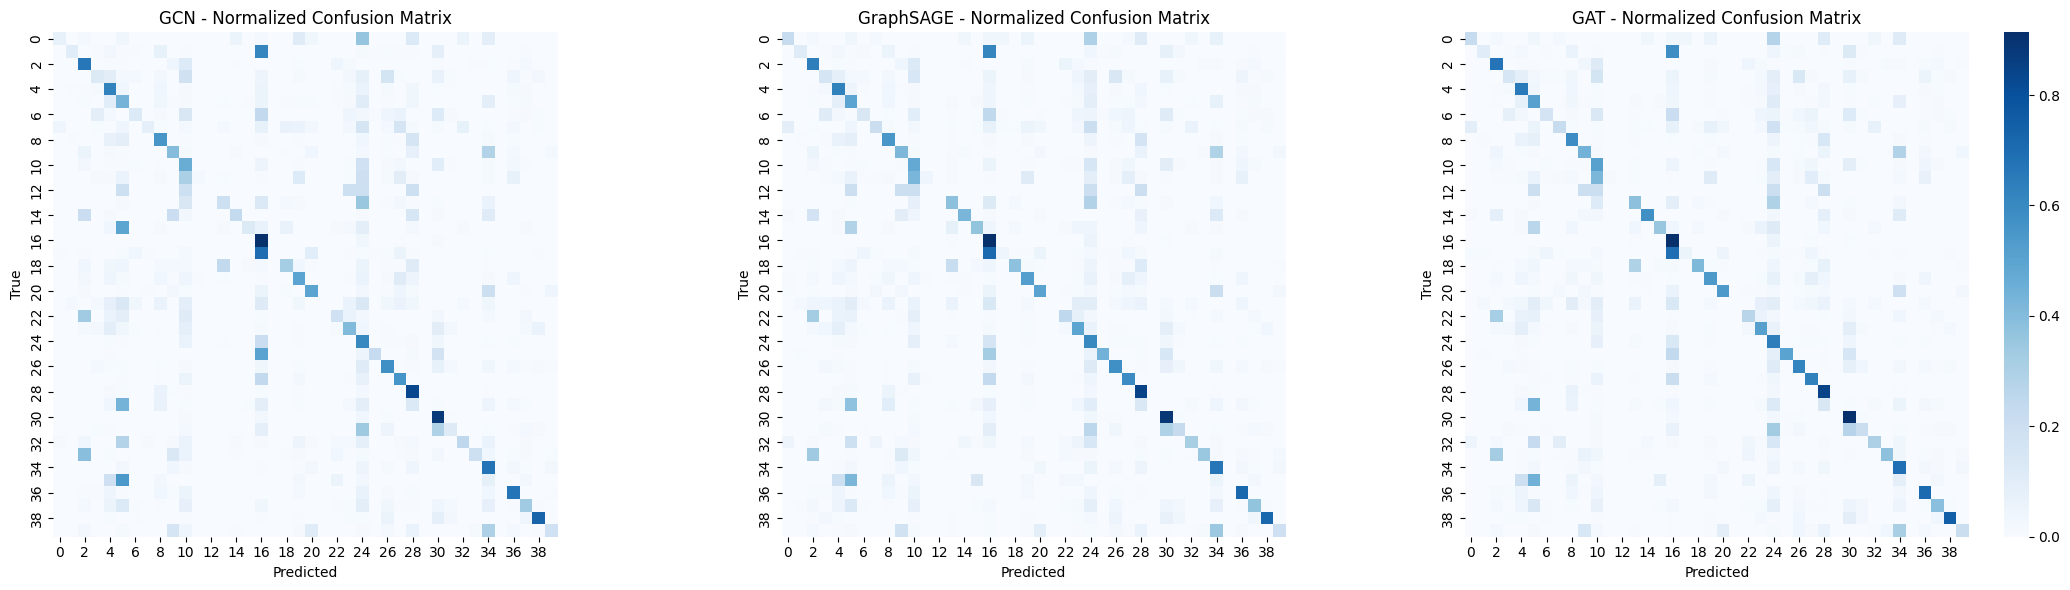

In [56]:
model_names = ["GCN", "GraphSAGE", "GAT"]
fig, axs = plt.subplots(1, 3, figsize=(22, 6))

for idx, name in enumerate(model_names):
    model = final_models[name]
    model.eval()
    out = model(data.x, data.edge_index)

    pred = out.argmax(dim=-1).cpu().numpy()
    true = data.y.squeeze(1).cpu().numpy()
    pred_test = pred[test_idx.cpu()]
    true_test = true[test_idx.cpu()]

    cm = confusion_matrix(true_test, pred_test)
    cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    sns.heatmap(cm_normalized, ax=axs[idx], cmap="Blues", square=True, cbar=True if idx == 2 else False)
    axs[idx].set_title(f"{name} - Normalized Confusion Matrix")
    axs[idx].set_xlabel("Predicted")
    axs[idx].set_ylabel("True")

plt.tight_layout()
plt.show()
